# **Set up Environment**
---

1. Create a shortcut on the drive from https://drive.google.com/drive/folders/1pCEBqzQDTJ3PlgdIRBY65jOugJ4xpFi6?usp=sharing
2. Edit all file paths (marked with ## CHANGE ##) to fit ur  project environment

In [109]:
# pull git
%cd /content
# !git clone https://github.com/wilfredbtan/CS4243-Mini-Project.git # Uncomment this to clone it once
%cd CS4243-Mini-Project
!git pull
!git checkout master
!ls

/content
/content/CS4243-Mini-Project
Already up to date.
M	dataset.csv
M	initData.sh
M	splitTrainTest.sh
M	test_label.csv
M	train_label.csv
Already on 'master'
Your branch is up to date with 'origin/master'.
CS4243_MiniProject.ipynb  README.md	     test_out.pth
dataset.csv		  requirements.txt   train_label.csv
initData.sh		  splitTrainTest.sh  WeaponDetection.pth
model1.pth		  template.py
model_template.ipynb	  test_label.csv


In [110]:
!pip3 install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [111]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [112]:
! ls /content/drive/My\ Drive/cs4243_smallest

carrying  normal  threat


In [113]:
!bash initData.sh '/content/drive/My Drive/cs4243_smallest'
# Use below for local
# sh initData.sh '/cs4243_smallest'
!sh splitTrainTest.sh

File path: /content/drive/My Drive/cs4243_smallest
/content/drive/My Drive/cs4243_smallest/normal
/content/drive/My Drive/cs4243_smallest/carrying
/content/drive/My Drive/cs4243_smallest/threat


In [114]:
from collections import defaultdict
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

import torch
import torchvision
from torchvision.transforms import transforms
from torchvision import models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable

from PIL import Image
torch.manual_seed(42)

import torch.optim as optim
from torch.optim import Adam

# **Data Visualization and Data Preparation**

---



Distribution of dataset:

In [115]:
train_df = pd.read_csv("train_label.csv")
test_df = pd.read_csv("test_label.csv")
count = len(train_df)
normal_count = len(train_df[train_df["label"] == 0])
carrying_count = len(train_df[train_df["label"] == 1])
threat_count = len(train_df[train_df["label"] == 2])
print(f'TRAIN: Count: {count} - Normal: {normal_count*100/count:.2f}% - Carrying: {carrying_count*100/count:.2f}% - Threat: {threat_count*100/count:.2f}%')

count = len(test_df)
normal_count = len(test_df[test_df["label"] == 0])
carrying_count = len(test_df[test_df["label"] == 1])
threat_count = len(test_df[test_df["label"] == 2])
print(f'TEST: Count: {count} - Normal: {normal_count*100/count:.2f}% - Carrying: {carrying_count*100/count:.2f}% - Threat: {threat_count*100/count:.2f}%')

train_df.head()

TRAIN: Count: 3943 - Normal: 37.59% - Carrying: 31.27% - Threat: 31.14%
TEST: Count: 1000 - Normal: 37.50% - Carrying: 30.20% - Threat: 32.30%


,directory,label
0,normal/00000.42797_100.png,0
1,normal/00000.42797_200.png,0
2,normal/00000.42797_30.png,0
3,normal/00010.40911_100.png,0
4,normal/00010.40911_30.png,0


Preparing datapaths:

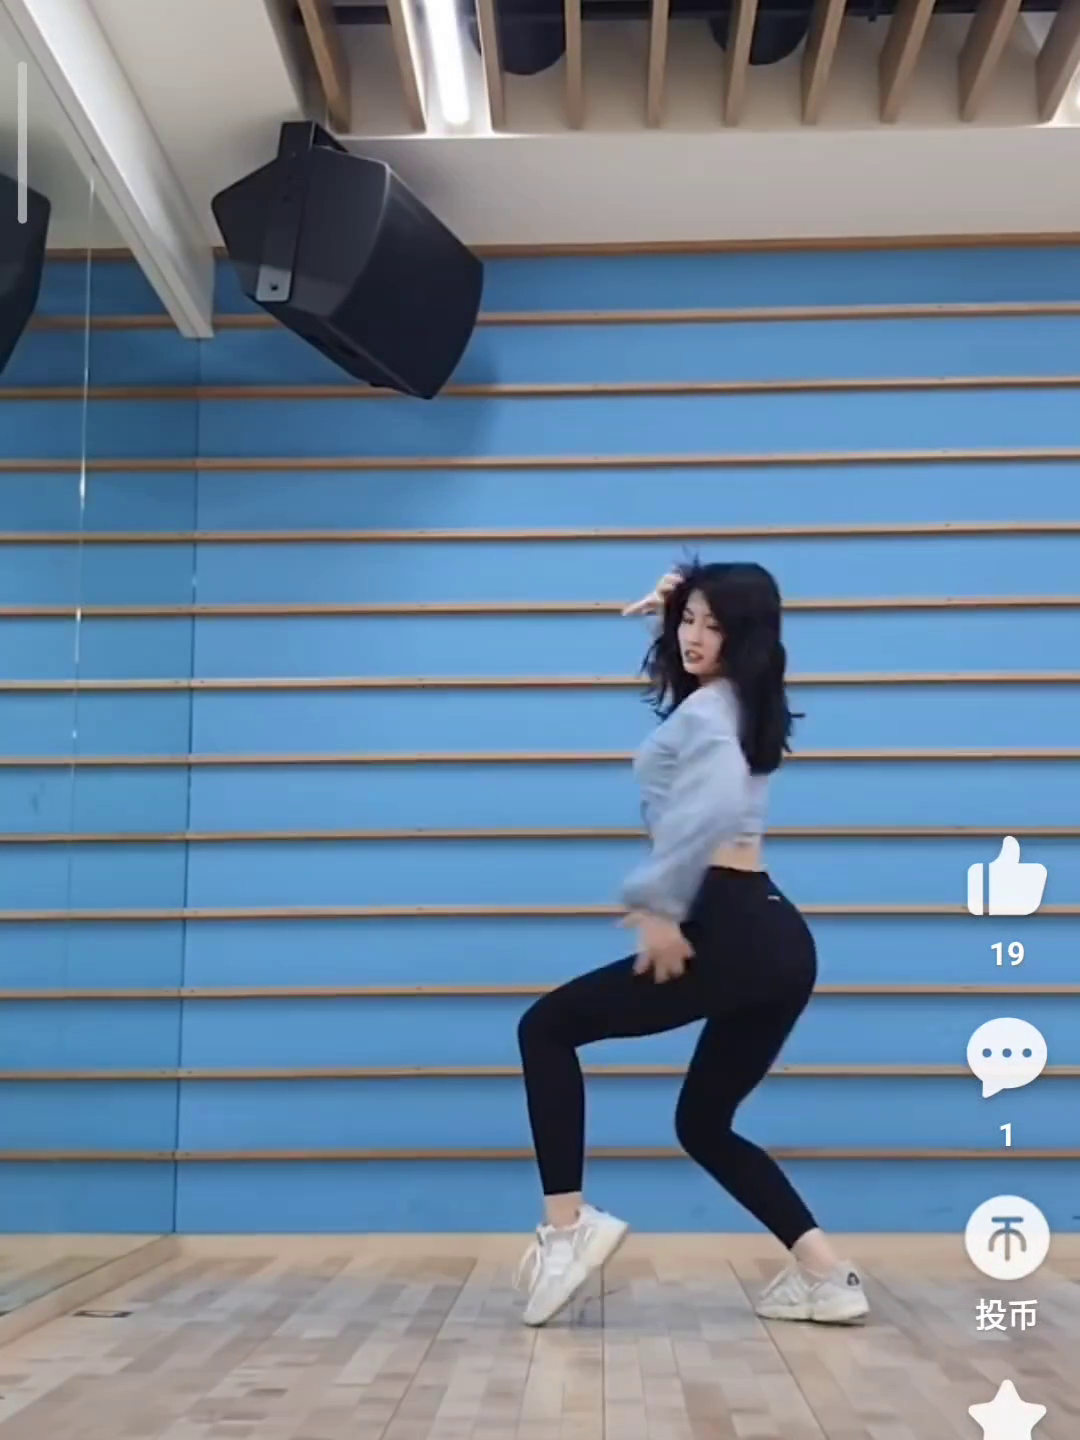

In [116]:
root = "/content/drive/My Drive/cs4243_smallest/" ## CHANGE ##
# root = "./cs4243_smallest/" # on local machine
img_path = train_df['directory'][0]

img = Image.open(root + str(img_path)) #similar to cv2.imread()
img

# Data Loader

---

In [117]:
class CS4243_dataset(Dataset): 
    def __init__(self, root_path , dataframe, transform=None):
        self.df = dataframe    
        self.transform = transform
        self.root_path = root_path
        
        self.image_paths = self.df['directory']
        self.labels = self.df['label']
                
    def __getitem__(self, index):
        img_path = self.image_paths[index] 
        image = Image.open(self.root_path + str(img_path))
        target = torch.tensor(self.labels[index])
      
        if self.transform != None:
            image = self.transform(image)
          
        return [image, target, img_path]
       
    def __len__(self):
        return len(self.df)

# **Neural Networks**
---

### **NETWORK 1**
2 Layers of CNN, max pooled, 2 layers of dense linear, no need for transform resize due to adaptive max pool

In [118]:
# Define a convolution neural network
class Network1(nn.Module):
    # def __init__(self, input_size, number_of_labels, dropout=0.3):
    #     super().__init__()
    #     self.conv1 = nn.Sequential(nn.Conv2d(input_size, 12, 5),
    #                                nn.ReLU(),
    #                                nn.MaxPool2d(2, 2))
    #     self.conv2 = nn.Sequential(nn.Conv2d(12, 16, 5),
    #                                nn.ReLU(),
    #                                nn.AdaptiveMaxPool2d((5, 5))) # can also use transformer instead to standardize input size
    #     self.fc1 = nn.Sequential(nn.Flatten(),
    #                              nn.Dropout(p=dropout),
    #                              nn.Linear(16 * 5 * 5, 120),
    #                              nn.ReLU())
    #     self.fc2 = nn.Sequential(nn.Linear(120, 84),
    #                              nn.ReLU())
    #     self.fc3 = nn.Linear(84, number_of_labels)

    # def forward(self, x):
        # h1 = self.conv1(x)
        # h2 = self.conv2(h1)
        # h3 = self.fc1(h2)
        # h4 = self.fc2(h3)
        # x = self.fc3(h4)
        # return x
  
    def __init__(self, input_size, number_of_labels, dropout=0.3):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(24)
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(24)
        self.fc1 = nn.Linear(24*10*10, 10)

    def forward(self, input):
        output = F.relu(self.bn1(self.conv1(input)))      
        output = F.relu(self.bn2(self.conv2(output)))     
        output = self.pool(output)                        
        output = F.relu(self.bn4(self.conv4(output)))     
        output = F.relu(self.bn5(self.conv5(output)))     
        output = output.view(-1, 24*10*10)
        output = self.fc1(output)

        return output

# **Training Function**
---

In [119]:
def train(model, data_loader, loss_fn, optimizer, num_epoch, device='cpu', model_path=None):
    start = datetime.datetime.now()

    for epoch in range(num_epoch):  # loop over the dataset multiple times
        model.train()
        running_loss = 0.0

        for i, (images, labels, _) in enumerate(data_loader, 0):
            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # zero the parameter gradients
            optimizer.zero_grad()
            # predict classes using images from the training set
            outputs = model(images)
            # compute the loss based on model output and real labels
            loss = loss_fn(outputs, labels)
            # backpropagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            optimizer.step()

            # print statistics for every 1,000 images
            running_loss += loss.item()     # extract the loss value
            if i % 10 == 9:    
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0

    end = datetime.datetime.now()
    print('Training finished in {} minutes.'.format((end - start).seconds / 60.0)) 
        
    if model_path != None:
        torch.save(model.state_dict(), model_path)
        print('Model saved in ', model_path)

# **Testing Function**
---

In [120]:
def test(model, data_loader, output_path, device='cpu', classes=None):
    model.eval()

    with open(output_path, 'w+') as f_output:
            with torch.no_grad():
                for (images, labels, image_paths) in data_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    # the label with the highest energy will be our prediction
                    _, predicted = torch.max(outputs.data, 1)
                    for i in range(len(images)):
                        label_i = labels[i].item()
                        predicted_i = predicted[i].item()
                        image_path_i = image_paths[i]
                        if classes != None:
                            label_i = classes[label_i]
                            predicted_i = classes[predicted_i]
                        f_output.write("{0}, {1}, {2}\n".format(label_i, predicted_i, image_path_i))

    # compute the accuracy over all test images
    print("Testing finished. Model saved in ", output_path)

In [121]:
# Function to show the images
def imageshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Evaluate output file
def show_test_accuracy(output_path, root="", transformer=None, show=0):
    correct = defaultdict(int)
    count = defaultdict(int)
    images = []
    show_target = []
    show_predicted = []

    with open(output_path) as f:
        lines = f.read().splitlines()
        for line in lines:
            target, predicted, image_path = line.split(", ")
            count[target] += 1
            if target == predicted:
                correct[target] += 1
            if len(images) < show:
                image = Image.open(root + str(image_path))
                if transformer != None:
                    image = transformer(image)
                images.append(image)
                show_target.append(target)
                show_predicted.append(predicted)
    
    total = [0, 0]
    for label in count:
        print("{0} accuracy: {1}/{2} = {3:.2f}%".format(label, correct[label], count[label], correct[label]/count[label]*100))
        total[1] += count[label]
        total[0] += correct[label]
    print("Overall accuracy: {0}/{1} = {2:.2f}%".format(total[0], total[1], total[0]/total[1]*100))
    
    if len(images) > 0:
        imageshow(torchvision.utils.make_grid(images))
        print("target: ", show_target)
        print("predicted: ", show_predicted)

# **Evaluation**

---


Normalize data using transformers:

In [122]:
transformations = transforms.Compose([
    transforms.Resize(size=(32,32),interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Dividing into batches:

In [123]:
batch_size = 256
classes = ('normal', 'carrying', 'threat')
num_of_labels = len(classes)

# normalize data using transformers
transformations = transforms.Compose([
    transforms.Resize(size=(32,32),interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# train
train_set = CS4243_dataset(root, train_df, transform = transformations)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle = True, drop_last=True)
print("The number of images in a training set is: ", len(train_loader)*batch_size)

# test
test_set = CS4243_dataset(root, test_df, transform=transformations)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=True)
print("The number of images in a test set is: ", len(test_loader)*batch_size)

print("The number of batches per epoch is: ", len(train_loader))

The number of images in a training set is:  3840
The number of images in a test set is:  768
The number of batches per epoch is:  15


Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer:

In [124]:
loss_fn = nn.CrossEntropyLoss
optimizer = Adam
optim_params = {'lr':0.001, 'weight_decay':0.0001}
epoch = 5
dropout = 0.1
model_path = "/content/drive/My Drive/cs4243 test/model1.pth" ## CHANGE ##
output_path = "/content/drive/My Drive/cs4243 test/test_out.pth" ## CHANGE ##
device = torch.device("cuda:0" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))

### **NETWORK 1**

In [ ]:
model1 = Network1(3, num_of_labels, dropout).to(device)
train(model1, train_loader, loss_fn(), 
      optimizer(model1.parameters(), **optim_params), epoch, device, model_path)

In [ ]:
model_path = "/content/drive/My Drive/cs4243 test/model1.pth" ## CHANGE ##

In [ ]:
model1 = Network1(3, num_of_labels, dropout).to(device)
model1.load_state_dict(torch.load(model_path))

test(model1, test_loader, output_path, device, classes)
show_test_accuracy(output_path, root, transformations, show=10)